In [2]:
from glob import glob
from PIL import Image
import numpy as np
from os.path import basename
import matplotlib.pylab as plt
import fnmatch
import cv2
import itertools
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import History 

/Users/MariaNuila/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Preparation of Images for our DataSet

In [3]:
#Path of the files:
path = "/Users/MariaNuila/Desktop/CECS406/IDC_regular_ps50_idx5/*/*/*.png"
width, height = 50, 50
pictures = glob(path)
#Separate images based on classification
nonIDC =  fnmatch.filter(pictures, '*class0.png')
IDC = fnmatch.filter(pictures, '*class1.png')


In [4]:
#Create training and testing data set from pictures
x = []
y = [] #labels
for pic in pictures[0:100000]:
    image = cv2.imread(pic)
    x.append(cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC))
    if pic in nonIDC:
        y.append(0)
    if pic in IDC:
        y.append(1)
#Place in dataframe:
df = pd.DataFrame()
df["images"] = x
df["labels"] = y

#vectorize and normalize data
x=np.array(x)
x=x/255.0
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

#Convert our training and testing data into np arrays:
xtrain_npArray = np.array(X_train)
xtest_npArray = np.array(X_test)
ytrain_npArray = np.array(Y_train)
ytest_npArray = np.array(Y_test)

In [6]:
input_shape = (50,50,3)
num_classes = 2
# convert class vectors to binary class matrices
ytrain_npArray = keras.utils.to_categorical(ytrain_npArray, num_classes)
ytest_npArray = keras.utils.to_categorical(ytest_npArray, num_classes)

In [7]:
#Specify Data training information: 
batch_size = 128
epochs = 8

# Build Fine tuned VGG16 Model From Keras

In [8]:
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [59]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [60]:
# Make our fine-tuned model sequential for easier processing
fine_tuned = Sequential()
#Add vgg layers to our model
for layers in vgg16_model.layers:
    fine_tuned.add(layers)

In [61]:
#Make the previous VGG model frozen with its current weights
for layers in fine_tuned.layers:
    layers.trainable = False

In [62]:
#Now add our fully connected layer:
fine_tuned.add(Flatten())
fine_tuned.add(Dense(64, activation='relu'))
fine_tuned.add(Dense(64, activation='relu'))
fine_tuned.add(Dropout(0.5))
fine_tuned.add(Dense(num_classes, activation='softmax'))

In [63]:
fine_tuned.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

# Train Fine-Tuned Model 

In [66]:
#use Adam optimizer based on stochastic optimization (Adam):
fine_tuned.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

In [67]:
fine_tuned.fit(xtrain_npArray, ytrain_npArray,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest_npArray, ytest_npArray))

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 1343s 17ms/step - loss: 0.4179 - acc: 0.8228 - val_loss: 0.3883 - val_acc: 0.8353
Epoch 2/50
80000/80000 [==============================] - 1347s 17ms/step - loss: 0.4039 - acc: 0.8294 - val_loss: 0.3792 - val_acc: 0.8357
Epoch 3/50
80000/80000 [==============================] - 1373s 17ms/step - loss: 0.3954 - acc: 0.8330 - val_loss: 0.3720 - val_acc: 0.8417
Epoch 4/50
80000/80000 [==============================] - 1359s 17ms/step - loss: 0.3885 - acc: 0.8360 - val_loss: 0.3679 - val_acc: 0.8429
Epoch 5/50
80000/80000 [==============================] - 1370s 17ms/step - loss: 0.3829 - acc: 0.8375 - val_loss: 0.3629 - val_acc: 0.8435
Epoch 6/50
80000/80000 [==============================] - 1369s 17ms/step - loss: 0.3791 - acc: 0.8395 - val_loss: 0.3590 - val_acc: 0.8458
Epoch 7/50
80000/80000 [==============================] - 1928s 24ms/step - loss: 0.3751 - acc: 0.8411 - val_l

In [68]:
score = fine_tuned.evaluate(xtest_npArray, ytest_npArray, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35027360521554946
Test accuracy: 0.85505


# Predict using our Fine-tuned Model:


In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [90]:
y_pred = fine_tuned.predict(xtest_npArray)

In [85]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print('\n', classification_report(np.where(ytest_npArray > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    


             precision    recall  f1-score   support

     IDC(-)       0.87      0.95      0.91     15078
     IDC(+)       0.79      0.56      0.66      4922

avg / total       0.85      0.86      0.85     20000



In [87]:
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(ytest_npArray,axis=1) 

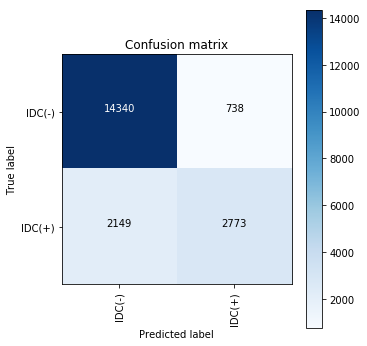

In [92]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

# Create another model to compare smaller number of epochs and a different optimizer

In [9]:
# Make our fine-tuned model sequential for easier processing
fine_tuned2 = Sequential()
#Add vgg layers to our model
for layers in vgg16_model.layers:
    fine_tuned2.add(layers)
    

In [10]:
#Make the previous VGG model frozen with its current weights
for layers in fine_tuned2.layers:
    layers.trainable = False

In [11]:
#Now add our fully connected layer:
fine_tuned2.add(Flatten())
fine_tuned2.add(Dense(64, activation='relu'))
fine_tuned2.add(Dense(64, activation='relu'))
fine_tuned2.add(Dropout(0.5))
fine_tuned2.add(Dense(num_classes, activation='softmax'))

In [13]:
fine_tuned2.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adagrad(lr=.001),
                  metrics=['accuracy'])

In [14]:
history = fine_tuned2.fit(xtrain_npArray, ytrain_npArray,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest_npArray, ytest_npArray))

Train on 80000 samples, validate on 20000 samples
Epoch 1/8
80000/80000 [==============================] - 1624s 20ms/step - loss: 0.4879 - acc: 0.7766 - val_loss: 0.4213 - val_acc: 0.8198
Epoch 2/8
80000/80000 [==============================] - 1370s 17ms/step - loss: 0.4310 - acc: 0.8138 - val_loss: 0.4075 - val_acc: 0.8266
Epoch 3/8
80000/80000 [==============================] - 1365s 17ms/step - loss: 0.4204 - acc: 0.8191 - val_loss: 0.4029 - val_acc: 0.8287
Epoch 4/8
80000/80000 [==============================] - 1342s 17ms/step - loss: 0.4145 - acc: 0.8226 - val_loss: 0.3990 - val_acc: 0.8290
Epoch 5/8
80000/80000 [==============================] - 1370s 17ms/step - loss: 0.4112 - acc: 0.8244 - val_loss: 0.3966 - val_acc: 0.8300
Epoch 6/8
80000/80000 [==============================] - 1369s 17ms/step - loss: 0.4082 - acc: 0.8258 - val_loss: 0.3948 - val_acc: 0.8304
Epoch 7/8
80000/80000 [==============================] - 1357s 17ms/step - loss: 0.4063 - acc: 0.8273 - val_loss: 0.

In [15]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["acc"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_acc"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

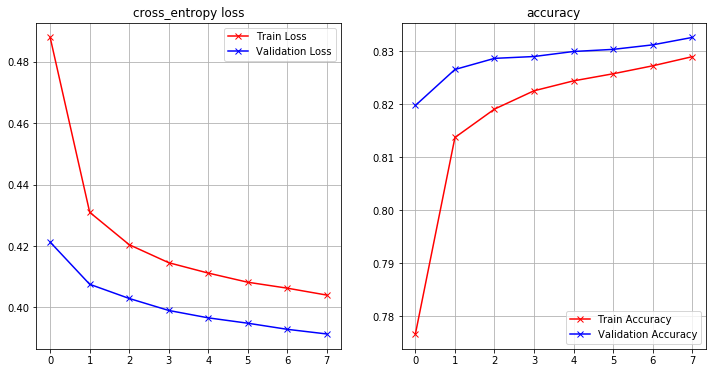

In [17]:
plot_loss_accuracy(history)

In [16]:
score = fine_tuned2.evaluate(xtest_npArray, ytest_npArray, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3913321305513382
Test accuracy: 0.83265
